## Prediction of tropical storms intensity

In [2]:
# Packages loading
import os
import pandas as pd
import numpy as np

# for ploting map
import matplotlib.pyplot as plt
import geopandas as gpd

import plotly.express as px

# Preprocessing
from sklearn.preprocessing import (
    OrdinalEncoder
)


In [4]:
# Change current working directory
# current directory:
print(os.getcwd())
# set new directory
os.chdir('D:\_DSTI\A24_Python_Machine_learning\Project3_Tropical_storms')


D:\_DSTI\A24_Python_Machine_learning\Project3_Tropical_storms


## Dataset loading
IBTrACS dataset from NOAA.
International Best Track Archive for Climate Stewardship.
https://www.ncei.noaa.gov/products/international-best-track-archive

Objectif of the project :
Train a model to predict the severity of a tropical cyclone based on geographical input data.
Especially, we need to focus on predicting the value in the <b>TD9636_STAGE</b> column.




In [5]:
# Dataset loading
df = pd.read_csv('.\ibtracs.csv', header=0) 
df = df.iloc[1:] # remove 2nd line (with index 1).
df = df.reset_index() #reset indexes ;
# Add a column "Index" corresponding to the previous indexes. Can be removed.
#storms.head()
#print(storms)
# storms: dataframe 297098 lines, 175 columns (174 + 1 for old indexes)


C:\Users\Claire\AppData\Local\Temp\ipykernel_26576\2115829982.py:2: DtypeWarning: Columns (1,2,8,9,14,19,20,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('.\ibtracs.csv', header=0)


As we need to focus on the value in the <b>TD9636_STAGE</b> column, we can remove all lines where <b>TD9636_STAGE</b> is missing.
The TD9636 dataset was build in the 60-70s and is a collection of storms derived from multiple sources. It has not been updated since the 80s whereas the IBTrACS dataset is still updated. As a consequence it is not suprising that most of rows in TD9636_STAGE are empty.
TD9636 is a dataset for outside the Atlantic.

PROBLEM: 
Empty cells are in fact filled with a whitespace and thus NA are not properly detected

In [ ]:
df.isna().sum()# it seems that there is no NA, which is false.

index                0
SID                  0
SEASON               0
NUMBER               0
BASIN            40518
                 ...  
USA_SEARAD_SE        0
USA_SEARAD_SW        0
USA_SEARAD_NW        0
STORM_SPEED          0
STORM_DIR            0
Length: 175, dtype: int64

: 

In [6]:
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x) # remove whitespace from every cells
df.replace('', np.nan, inplace=True) # replace empty cells with NaN
df_NA = df.isna().sum() # it seems to work. 
# We can remove all columns filled only with NA

C:\Users\Claire\AppData\Local\Temp\ipykernel_26576\3573423944.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x) # remove whitespace from every cells
C:\Users\Claire\AppData\Local\Temp\ipykernel_26576\3573423944.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('', np.nan, inplace=True) # replace empty cells with NaN


In [7]:
# Now we can remove rows where there is NA in TD9636_STAGE
# TD9636_STAGE : 248755 missing data (84%)

df.dropna(subset = ['TD9636_STAGE'], inplace=True)

# Only 48343 rows left

In [9]:
df.TD9636_STAGE.value_counts()


TD9636_STAGE
2    17204
1    16028
4    10623
0     3156
3      742
5      331
6      259
Name: count, dtype: int64

# Data cleaning/feature engineering

First remove all rows filled only with NA :
- 75 columns

Columns to remove:

    - index: column added by Python when updating indexes after removing the 2nd line.
    - NAME: same as SID except that some storms don't have name. Redundant info
    - NUMBER: number of the storm for the year. Restart at 1 each year. Not useful.
    - BASIN 
    - SUBBASIN: Mostly missing. These two will probably be correlated to LAT and LON. Redundant info.
    - WMO_WIND: all data from agencies but differents units but no adjustement is made for differences in wind speed averaging. Data not comparable.
    - TD9636_WIND: in data description: "subjective, must be interpreted with caution". Not reliable.
    - WMO_AGENCY: info on agency from where WMO_ data come from.

    - IFLAG: info about data quality. Not necessary for model.
    - TRACK_TYPE: info about data quality. Not necessary for model.

    - BOM_PRES_METHOD: info on how BOM_PRES is measured

    - DS824_STAGE: lot of missing data but not surprising as it cover the period between 1877 and 1980. Our data are until 1989 thus we can remove this column.

    -NEUMANN_CLASS: lot of missing data. Not surprising as it cover only Southern Hemisphere and thus does not cover our entire study area.



Columns to keep: 

    - SID: unique ID for each storm
    - ISO_TIME: uniquely identify each record ? 
    - DIST2LAND
    - LANDFALL
    - LAT
    - LON

In [8]:
# Sum of NA per column:
df_NA = df.isna().sum() 
# Remove columns filled with NA
df = df.dropna(axis=1, how='all')
df_NA = df.isna().sum() 

In [9]:
# Columns that are not useful/full of NA/not reliable:
STORMS = df.drop(columns=['index', 'NAME', 'NUMBER',
                                    'SUBBASIN',
                                    'WMO_WIND', 'TD9636_WIND', 
                                    'WMO_AGENCY',
                                    'IFLAG', 'TRACK_TYPE',
                                    'BOM_PRES_METHOD',
                                    'DS824_STAGE',
                                    'NEUMANN_CLASS'
                                    ])

In [10]:
# Remove duplicate LAT/LON data:
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('_LAT', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('_LON', case=True)]

In [ ]:
STORMS.TD9636_STAGE.value_counts()

# stage are not equally represented, which is not suprising.
# but will be a problem for the model ?

TD9636_STAGE
2    17204
1    16028
4    10623
0     3156
3      742
5      331
6      259
Name: count, dtype: int64

: 

In [11]:
df.BASIN.value_counts()


BASIN
WP    19796
SI    11008
EP     9831
SP     5752
NI     1956
Name: count, dtype: int64

Data available for
WP: Western North Pacific
SI: South Indian
EP: Eastern North Pacific
SP: South Pacific
NI: North Indian 

No data for North and South Atlantic (NA and SA) which is normal as TD9636 is a dataset for outside the Atlantic.

## WIND columns
_WIND columsn from the different agencies have different units, and thus can not be gather together easily :
     WMO_WIND: all data from agencies but differents units (no adjustement is made for differences in wind speed averaging)
     I suggest to remove it. No reliable.

     USA_WIND, DS824_WIND, NEUMANN_WIND, max speed 1-min averaged;
     CMA_WIND, max speed 2-min averaged;
     NEWDELHI_WIND, max speed 3-min averaged;
     TOKYO_WIND, HKO_WIND, KMA_WIND, REUNION_WIND, BOM_WIND, NADI_WIND, WELLINGTON_WIND max speed 10-min averaged;
     TD9636_WIND: in data description "estimates subjective, interpreted with caution". Remove it. 
     TD9635_WIND, MLC_WIND: only NA

We can take USA_WIND as a base because it is where there is the less NAN and complete the missing data with other columns, especially DS824_WIND and NEUMANN_WIND as it is supposed to be the same unit (max speed 1-min averaged).
Problem: data are not in the same unit 
To convert from max speed 10-min averaged to 1-min averaged : * 1.12
IBTrACS technical details p5: 
    "The U.S. agencies (NOAA and JTWC) report a 1 min averaging time for the sustained (i.e. relatively long-lasting) winds. In most of the rest of the world, a 10 min averaging time is used for "sustained wind". It is possible to convert from peak 10 min wind to peak 1 min wind (roughly 12% higher for the latter) as a general rule."
It is not a very accurate method so I suggest not to use it too much.
(See part 6.2 Wind speed reporting differences from Technical details doc)

We create one column WIND to gather all wind data and one column AGENCY to track the origin of the data.

In [12]:
# convert data types : 
cols = STORMS.filter(like="_WIND").columns
STORMS[cols] = STORMS[cols].apply(pd.to_numeric, errors="coerce")
STORMS.dtypes

# Create the two columns "WIND" and "AGENCY":
STORMS["WIND"] = np.nan
STORMS["WIND_AGENCY"] = np.nan

sources_adj = [
    ("USA_WIND", 1.0),  # No adjustment
    ("DS824_WIND", 1.0),  # No adjustment
    ("NEUMANN_WIND", 1.0),  # No adjustment
    ("TOKYO_WIND", 1.12),  # Adjustment factor
    ("HKO_WIND", 1.12),
 #   ("KMA_WIND", 1.12),
    ("REUNION_WIND", 1.12),
    ("BOM_WIND", 1.12),
 #   ("NADI_WIND", 1.12),
    ("WELLINGTON_WIND", 1.12)
]

# Iterate through the sources
for source, factor in sources_adj:
    mask = pd.isna(STORMS["WIND"]) & ~pd.isna(STORMS[source])  # Where WIND is NA but source is not NA
    STORMS.loc[mask, "WIND"] = STORMS.loc[mask, source] * factor
    STORMS.loc[mask, "WIND_AGENCY"] = source

C:\Users\Claire\AppData\Local\Temp\ipykernel_26576\4145608872.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'USA_WIND' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  STORMS.loc[mask, "WIND_AGENCY"] = source


In [13]:
# Then we can remove other _WIND columns
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('_WIND', case=True)]

# PRESS columns

= Lowest surface pressure in the tropical cyclone
Supposed to be easily comparable between agencies.

     WMO_PRES: Minimal central pressure assigned by the responsible WMO Agency
     USA_PRES: (mb) Minimum sea level pressure. Seems less precise ?
     TOKYO_PRES: central pressure
     CMA_PRES: (mb) Minimum sea level pressure
     HKO_PRES: (mb) Minimum sea level pressure
     KMA_PRES: (mb) Minimum sea level pressure
     NEWDELHI_PRES: 
     REUNION_PRES:
     BOM_PRES 
     BOM_PRES_METHOD: indicate the tool, not useful for us?
     NADI_PRES:
     WELLINGTON_PRES
     DS824_PRES
     NEUMANN_PRES

Except BOM_PRES_METHOD, they all have the same unit and should be comparable.


In [14]:
# Problem: not exactly the same value and the LAT and LON are not EXACTLY the same.
PRES = STORMS.filter(like="PRES", axis =1)
PRES.isna().sum()

# Maybe we can do the mean of each value. 
# It will modify the data but smooth the error ?

WMO_PRES           33584
USA_PRES           46775
TOKYO_PRES         32937
CMA_PRES           33176
HKO_PRES           35341
NEWDELHI_PRES      48118
REUNION_PRES       45186
BOM_PRES           42193
WELLINGTON_PRES    43960
DS824_PRES         47998
NEUMANN_PRES       45442
dtype: int64

In [15]:
# convert data types : 
cols = STORMS.filter(like="_PRES").columns
STORMS[cols] = STORMS[cols].apply(pd.to_numeric, errors="coerce")
STORMS.dtypes

# create a new column PRESS that is the mean of all _PRESS columns
STORMS["PRESS"] = STORMS.filter(like = "_PRES") . mean(axis = 1)


In [16]:
# Then we can remove other _PRES columns
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('_PRES', case=True)]

In [17]:
# Remove data from agency columns
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('USA_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('TOKYO_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('CMA_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('HKO_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('NEWDELHI_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('REUNION_', case=True)]
STORMS = STORMS.loc[:, ~STORMS.columns.str.contains('BOM_', case=True)]

### At last we have :
14 columns:

    - SID: storm IDs
    - SEASON: Risk to be correlated with ISO_TIME ?
    - ISO_TIME: time of the measurement 
    - NATURE: ?
    - BASIN
    - LAT
    - LON
    - DIST2LAND 
    - LANDFALL
    - TD9636_STAGE: TARGET
    - STORM_SPEED: will be correlated to WIND ?
    - STORM_DIR
    - WIND
    - WIND_AGENCY: Not useful for the model
    - PRESS

### Problem:
Still a lot of missing data for PRESS

-----------------------
# Stop there
-----------------------
### Details on column choice

In [ ]:
# List of storms
IDS = df.loc[:, ["SID", "NAME", "NUMBER"]] 
# SID and Name are the same except that some storms don't have names so let's keep SID and remove Name
# NUMBER is the number of the storm for the year. Restart at 1 each year. Remove it. 
IDS.describe() # There are 4767 different storms
IDS.isna().sum() # No NA in SID. 

SID       0
NAME      0
NUMBER    0
dtype: int64

: 

In [ ]:
# LAT columns
LAT = STORMS.filter(like="LAT", axis=1) # All columns containing "LAT" in their headers
LAT = STORMS[["SID"] + [col for col in STORMS.columns if "LAT" in col]]
# All latitudes are the same most of the time (+- 0.1, sometimes more but mostly the same).
# All these columns contains the same information. 
# LAT = LAT.loc[:, ['LAT']]
# LAT.isna().sum() # No na in column LAT

: 

In [ ]:
# LONGITUDE
LON = STORMS.filter(like="LON", axis=1)
LON.isna().sum()
# same as with LAT, all longitudes are the same most of the time (+- 0.1, sometimes more but mostly the same).
# All these columns contains the same information. 
# LON = LON.loc[:, ['LON']]
# LON.isna().sum() # No na in column LAT

LON    0
dtype: int64

: 

PROBLEM:
Sometime LAT/LON data are the same between agencies but sometimes we can see differences. 
Why ?
Is it because the measurements are not take exactly at the same point or is it because of measurement inaccuracies between instruments ?


Plot a few storms on a map:

In [ ]:
# Extract storms that have different LAT/LON within a same line:

sample_ID = ["1980069S12161",
             "1980092S15183", 
             "1980197N07154",
             "1981070N03173"]
sample = STORMS[STORMS["SID"].isin(sample_ID)] 

sample = sample[["SID"] 
                + ["ISO_TIME"] 
                + [col for col in sample.columns if "LAT" in col]
                + [col for col in sample.columns if "LON" in col]
                ]
sample_one = sample[["SID"] + ["LAT"] + ["LON"]]


: 

In [ ]:
# Transpose the table

# Unpivot latitude and longitude columns
lat_melt = sample.melt(id_vars=['SID', 'ISO_TIME'], 
                   value_vars=[col for col in df.columns if col.endswith('_LAT')], 
                   var_name='agency_lat', 
                   value_name='latitude')

lon_melt = df.melt(id_vars=['SID', 'ISO_TIME'], 
                   value_vars=[col for col in df.columns if col.endswith('_LON')], 
                   var_name='agency_lon', 
                   value_name='longitude')

# Ensure the order matches between lat and lon
lat_melt['agency'] = lat_melt['agency_lat'].str.replace('_LAT', '', regex=False)
lon_melt['agency'] = lon_melt['agency_lon'].str.replace('_LON', '', regex=False)

# Merge latitude and longitude on ID, ISO_TIME, and agency
sample = pd.merge(lat_melt, lon_melt, on=['SID', 'ISO_TIME', 'agency'])

# Drop unnecessary columns
sample = sample.drop(columns=['agency_lat', 'agency_lon'])
sample = sample.dropna(subset = ["latitude"])


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['USA_LAT', 'TOKYO_LAT', 'CMA_LAT', 'HKO_LAT', 'NEWDELHI_LAT', 'REUNION_LAT', 'BOM_LAT', 'WELLINGTON_LAT', 'DS824_LAT', 'TD9636_LAT', 'NEUMANN_LAT']"

: 

Plot the map storms with all the points

In [ ]:
fig = px.scatter_geo(sample, 
                     lat = "latitude",
                     lon = "longitude",
                     color = "SID",
                     projection="natural earth"
                    )
fig.show()

: 

When zooming on the map, we can see that points sometimes there are points closed to the other one but the storm seems to have the same trajectory, just shifted. 
Therefore the difference between the differents LAT/LON pairs seem to be a matter of measurements inaccuracy.
We can keep just one.

In [ ]:
# Plot with only LAT LON

fig = px.scatter_geo(sample_one, 
                     lat = "LAT",
                     lon = "LON",
                     color = "SID",
                     projection="natural earth"
                    )
fig.show()


: 

We don't loose a lot of information if we keep only LAT and LON.
_____________________________________________________________________

_____________________________________________________________________
# Plot Report
_____________________________________________________________________

In [18]:
# convert data types : 
STORMS = STORMS.apply(pd.to_numeric, errors="ignore")
STORMS.dtypes

C:\Users\Claire\AppData\Local\Temp\ipykernel_26576\1183900853.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  STORMS = STORMS.apply(pd.to_numeric, errors="ignore")


SID              object
SEASON            int64
BASIN            object
ISO_TIME         object
NATURE           object
LAT             float64
LON             float64
DIST2LAND         int64
LANDFALL        float64
TD9636_STAGE      int64
STORM_SPEED     float64
STORM_DIR       float64
WIND            float64
WIND_AGENCY      object
PRESS           float64
dtype: object

In [19]:
import random

# select a few SID
sample_ID = random.sample(list(STORMS["SID"].unique()), 100)

# select a few SID in the STORMS database
sample_data = STORMS[STORMS["SID"].isin(sample_ID)] 

sample_data.to_csv("sample_data.csv", index=False)


In [ ]:
sample_data.dtypes

SID              object
SEASON            int64
ISO_TIME         object
NATURE           object
LAT             float64
LON             float64
DIST2LAND         int64
LANDFALL        float64
TD9636_STAGE      int64
STORM_SPEED     float64
STORM_DIR       float64
WIND            float64
WIND_AGENCY      object
PRESS           float64
dtype: object

: 

In [ ]:
fig = px.scatter_geo(
     sample_data,
     lat="LAT",  
     lon="LON",  
     color="TD9636_STAGE",  # Color markers based on pressure
     size="WIND",  # Size markers based on wind speed
 #    hover_name="PRESS",  
     projection="natural earth"  # Map projection type
 )

 # Customize layout (optional)
fig.update_layout(
     title="Cyclone over the earth",
     geo=dict(
         showland=True,  # Show land on the map
         landcolor="lightgray",  # Land color
         showcountries=True,  # Show country borders
         countrycolor="black"  # Country border color
     )
 )

 # Show the figure
fig.show()

: 

### Boxplot Pressure

C:\Users\Claire\AppData\Local\Temp\ipykernel_13664\1216009544.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "TD9636_STAGE",
C:\Users\Claire\AppData\Local\Temp\ipykernel_13664\1216009544.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\Claire\AppData\Local\Temp\ipykernel_13664\1216009544.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\Claire\AppData\Local\Temp\ipykernel_13664\1216009544.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. As

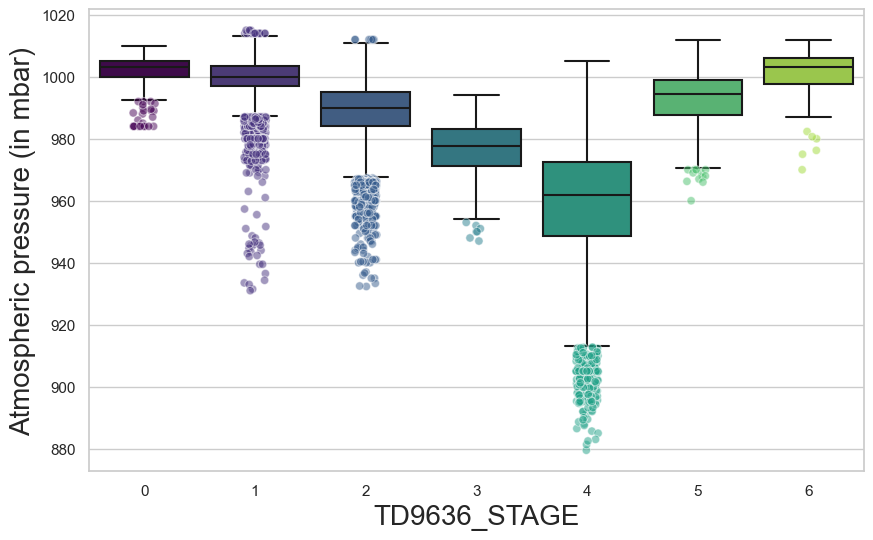

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style = "whitegrid")

# custom palette for all the graphs:
custom_color = {
    '0': '#440154',
    '1': '#46327e',
    '2': '#365c8d',
    '3': '#277f8e',
    '4': '#1fa187',
    '5': '#4ac16d',
    '6': '#a0da39',    
    '7': '#fde725'
} 

# configure figure size:
fig, ax = plt.subplots(figsize = (10, 6))

sns.boxplot(x = "TD9636_STAGE", 
            y = "PRESS", 
            data = STORMS, 
            palette = custom_color,   
            linewidth=1.5,  # Border width of boxes
            showfliers=False,  # Hide outliers
            ax = ax
            
            )

# Manually extract and plot **only the outliers**
for stage in STORMS["TD9636_STAGE"].unique():
    subset = STORMS[STORMS["TD9636_STAGE"] == stage]
    
    # Compute IQR (Interquartile Range) for outlier detection
    Q1 = subset["PRESS"].quantile(0.25)
    Q3 = subset["PRESS"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Select only outliers
    outliers = subset[(subset["PRESS"] < lower_bound) | (subset["PRESS"] > upper_bound)]
    
    # Plot outliers with matching color
    sns.stripplot(
        x=outliers["TD9636_STAGE"], 
        y=outliers["PRESS"], 
        palette=custom_color,  # Assign color based on stage
        marker='o',  
        alpha=0.5,  # Slight transparency
        size=6,  # Dot size
        edgecolor="white",  # Black border around dots
        linewidth=0.7,  
        ax=ax
    )

ax.set_xlabel("TD9636_STAGE", fontsize = 20) # x axis label
ax.set_ylabel("Atmospheric pressure (in mbar)", fontsize = 20) # y axis label

# Show the figure
plt.show()

### Correlation matrix

#### preparation of the data for correlation matrix

In [20]:
DATA = STORMS.copy()

In [21]:
# creation of a function to extract the season from the date and the latitude
def get_season(date, latitude):
    month = date.month
    day = date.day

    if latitude >= 0:  # Northern Hemisphere
        match month:
            case 12 | 1 | 2: 
                return "Winter"
            case 3 | 4 | 5: 
                return "Spring"
            case 6 | 7 | 8:
                return "Summer"
            case 9 | 10 | 11: 
                return "Fall"
    
    else:  # Southern Hemisphere
        match month:
            case 12 | 1 | 2:
                return "Summer"
            case 3 | 4 | 5: 
                return  "Fall"
            case 6 | 7 | 8: 
                return "Winter"
            case 9 | 10 | 11: 
                return "Spring"

In [22]:
# Convert ISO_TIME to datetime
DATA['ISO_TIME'] = pd.to_datetime(DATA['ISO_TIME'])
DATA['SEASON'] = DATA.apply(lambda row: get_season(row['ISO_TIME'], row['LAT']), axis=1)

In [23]:
# Encoding the NATURE and BASIN columns (just for the correlation matrix)
encoder = OrdinalEncoder()
DATA['NATURE'] = encoder.fit_transform(DATA[['NATURE']])

DATA['BASIN'] = encoder.fit_transform(DATA[['BASIN']])

In [24]:
# Encoding the SEASON column
# Recode the season in integers. Give more importance to the seasons where the most storms occur
encoder = OrdinalEncoder(categories = [['Winter', 'Spring', 'Fall', 'Summer']]) 
DATA['SEASON'] = encoder.fit_transform(DATA[['SEASON']])


In [25]:
DATA = DATA.drop(columns=['SID', 'ISO_TIME', 'WIND_AGENCY'])

In [33]:
# Correlation matrix + heatmap using Plotly for the transformed data
# Checking the correlations to check our hypothesis before using the data with the ML Model
cm_df = DATA.corr()
#cm_df = cm_df[((cm_df >= 0.2) | (cm_df <= -0.2)) & (cm_df != 1.00)]
cm_df = cm_df.where((cm_df >= 0.15) | (cm_df <= -0.15))
cm_df = cm_df.dropna(how="all", axis=0).dropna(how="all", axis=1)

# Move "TD9636_STAGE" parameters to the right (columns) and bottom (rows)
td9636_stage_columns = [col for col in cm_df.columns if "TD9636_STAGE" in col]
other_columns = [col for col in cm_df.columns if col not in td9636_stage_columns]

# Reordering DataFrame
cm_df = cm_df[other_columns + td9636_stage_columns]  # Move columns
cm_df = cm_df.loc[other_columns + td9636_stage_columns]  # Move rows

fig = px.imshow(
    cm_df,
    text_auto=".2f",
    zmin=-1,
    zmax=1,
    color_continuous_scale=px.colors.sequential.RdBu_r,
    title="Correlation Matrix Heatmap",
)
# Modify labels: make "TD9636_STAGE" parameters bold using HTML
formatted_labels = [
    f"<b>{col}</b>" if "TD9636_STAGE" in col else col for col in cm_df.columns
]


# Layout and show
fig.update_layout(
    template = "plotly_white",
    title="Correlation Matrix",
    autosize=False,
    width=900,
    height=700,
)
fig.update_yaxes(linewidth=1, linecolor='black', mirror=True, ticks='inside', showline=True,
                 tickfont=dict(size=14, color='black', weight="bold"))
fig.update_xaxes(linewidth=1, linecolor='black', mirror=True, ticks='inside', showline=True,
                 tickfont=dict(size=14, color='black', weight="bold"))
fig.show()